# ML Algorithm Application to fMRI data for Gender Classification

In [59]:
# Importing all required libraries

from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets
from nilearn import plotting as niplot
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


In [2]:
# Let's keep our notebook clean, so it's a little more readable!

import warnings
warnings.filterwarnings('ignore')

In [3]:
# To view the plots inline with code

%matplotlib inline

# Data Exploration

In [4]:
# Lets fetch the data!

data = datasets.fetch_development_fmri()

In [5]:
data.keys()

dict_keys(['func', 'confounds', 'phenotypic', 'description'])

In [6]:
# Lets explore data.func


print("Length of data.func", len(data.func))  ## Total Subjects
print("Type of data.func is:", type(data.func))
print("Value stored in data.func[0]",data.func[0]) ## data.func[0] is first element of data.func


Length of data.func 155
Type of data.func is: <class 'list'>
Value stored in data.func[0] /home/tjays/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


In [7]:
# Explore data.phenotypic

print("Type of data.phenotypic is:", type(data.phenotypic))
print("Value stored in data.phenotypic[0]",data.phenotypic[0]) 


Type of data.phenotypic is: <class 'numpy.ndarray'>
Value stored in data.phenotypic[0] ('sub-pixar123', 27.06, 'Adult', 'adult', 'F', 'R')


In [8]:
# Display Data Description

print("Description of dataset: ", data.description)

Description of dataset:  b"The movie watching based brain development dataset (fMRI)\r\n\r\n\r\nNotes\r\n-----\r\nThis functional MRI dataset is used for teaching how to use\r\nmachine learning to predict age from naturalistic stimuli (movie)\r\nwatching with Nilearn.\r\n\r\nThe dataset consists of 50 children (ages 3-13) and 33 young adults (ages\r\n18-39). This dataset can be used to try to predict who are adults and\r\nwho are children.\r\n\r\nThe data is downsampled to 4mm resolution for convenience. The original\r\ndata is downloaded from OpenNeuro.\r\n\r\nFor full information about pre-processing steps on raw-fMRI data, have a look\r\nat README at https://osf.io/wjtyq/\r\n\r\nFull pre-processed data: https://osf.io/5hju4/files/\r\n\r\nRaw data can be accessed from : https://openneuro.org/datasets/ds000228/versions/1.0.0\r\n\r\nContent\r\n-------\r\n    :'func': functional MRI Nifti images (4D) per subject\r\n    :'confounds': TSV file contain nuisance information per subject\r\n 

In [9]:
# Assign data.phenotypic to a variable

pheno = data.phenotypic
print(pheno)

[('sub-pixar123', 27.06      , 'Adult', 'adult', 'F', 'R')
 ('sub-pixar124', 33.44      , 'Adult', 'adult', 'M', 'R')
 ('sub-pixar125', 31.        , 'Adult', 'adult', 'M', 'R')
 ('sub-pixar126', 19.        , 'Adult', 'adult', 'F', 'R')
 ('sub-pixar127', 23.        , 'Adult', 'adult', 'F', 'R')
 ('sub-pixar128', 27.        , 'Adult', 'adult', 'M', 'R')
 ('sub-pixar129', 23.        , 'Adult', 'adult', 'F', 'R')
 ('sub-pixar130', 21.        , 'Adult', 'adult', 'F', 'R')
 ('sub-pixar131', 39.        , 'Adult', 'adult', 'M', 'R')
 ('sub-pixar132', 22.        , 'Adult', 'adult', 'F', 'R')
 ('sub-pixar133', 21.        , 'Adult', 'adult', 'M', 'R')
 ('sub-pixar134', 25.        , 'Adult', 'adult', 'M', 'R')
 ('sub-pixar135', 21.        , 'Adult', 'adult', 'F', 'R')
 ('sub-pixar136', 25.        , 'Adult', 'adult', 'F', 'R')
 ('sub-pixar137', 34.        , 'Adult', 'adult', 'F', 'R')
 ('sub-pixar138', 28.        , 'Adult', 'adult', 'F', 'R')
 ('sub-pixar139', 18.        , 'Adult', 'adult', 'F', 'R

# Brain Parcellation for ROI Specification

In [10]:


#First, let's load a parcellation that we'd like to use
multiscale = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = multiscale.scale064

print('Atlas ROIs are located in nifti image (4D) at: %s' %
       atlas_filename)

Atlas ROIs are located in nifti image (4D) at: /home/tjays/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz


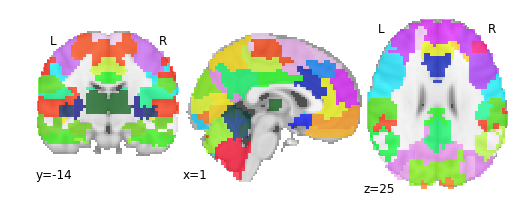

In [11]:
niplot.plot_roi(atlas_filename, draw_cross=False)

In [12]:
niplot.plot_roi

<function nilearn.plotting.img_plotting.plot_roi(roi_img, bg_img=<MNI152Template>, cut_coords=None, output_file=None, display_mode='ortho', figure=None, axes=None, title=None, annotate=True, draw_cross=True, black_bg='auto', threshold=0.5, alpha=0.7, cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7fd01b222610>, dim='auto', vmin=None, vmax=None, resampling_interpolation='nearest', **kwargs)>

# Generating Time-series of Single Subject

In [13]:
# initialize the masker from which we will retrieve a 2D array
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, 
                           memory='nilearn_cache', verbose=0)

In [14]:
# example with one participant
sub = data.func[0]
conf = data.confounds[0]

# Extract brain signal while removing confounds
time_series = masker.fit_transform(sub, confounds=conf)

In [15]:
time_series.shape

(168, 64)

# Correlation Matrices

In [16]:
# initialize correlation measure, to build a "connectome"

# set to vectorize (ready for our predictive model later on!)
vectorized_correlation_measure = ConnectivityMeasure(kind='correlation', discard_diagonal=True, vectorize=True)

# Just to visulalize single subect's correlation matrix
nonvectorized_correlation_measure = ConnectivityMeasure(kind='correlation', discard_diagonal=True)

In [17]:
nonvectorized_correlation_matrix = nonvectorized_correlation_measure.fit_transform([time_series])[0]
vectorized_correlation_matrix = vectorized_correlation_measure.fit_transform([time_series])[0]
print('Nonvectorized Correlation Matrix.shape: {}'.format(nonvectorized_correlation_matrix.shape))
print('vectorized_correlation_matrix.shape: {}'.format(vectorized_correlation_matrix.shape))

Nonvectorized Correlation Matrix.shape: (64, 64)
vectorized_correlation_matrix.shape: (2016,)


In [18]:

# Mask the main diagonal for visualization:
np.fill_diagonal(nonvectorized_correlation_matrix, 0)

# The labels we have start with the background (0), hence we skip the
# first label  
plotting.plot_matrix(nonvectorized_correlation_matrix, figure=(10, 8),   
                     labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)

# matrices are ordered for block-like representation

NameError: name 'plotting' is not defined

# Features Dataframe for Machine Learning 

In [134]:
all_features = [] # here is where we will put the data (a container)

for i,sub in enumerate(data.func):
    # extract the timeseries from the ROIs in the atlas
    time_series = masker.fit_transform(sub, confounds=data.confounds[i])
    # create a region x region correlation matrix
    vectorized_correlation_matrix = vectorized_correlation_measure.fit_transform([time_series])[0]
    # add to our container
    all_features.append(vectorized_correlation_matrix)
    # keep track of status
    print('finished %s of %s'%(i+1,len(data.func)))

finished 1 of 155
finished 2 of 155
finished 3 of 155
finished 4 of 155
finished 5 of 155
finished 6 of 155
finished 7 of 155
finished 8 of 155
finished 9 of 155
finished 10 of 155
finished 11 of 155
finished 12 of 155
finished 13 of 155
finished 14 of 155
finished 15 of 155
finished 16 of 155
finished 17 of 155
finished 18 of 155
finished 19 of 155
finished 20 of 155
finished 21 of 155
finished 22 of 155
finished 23 of 155
finished 24 of 155
finished 25 of 155
finished 26 of 155
finished 27 of 155
finished 28 of 155
finished 29 of 155
finished 30 of 155
finished 31 of 155
finished 32 of 155
finished 33 of 155
finished 34 of 155
finished 35 of 155
finished 36 of 155
finished 37 of 155
finished 38 of 155
finished 39 of 155
finished 40 of 155
finished 41 of 155
finished 42 of 155
finished 43 of 155
finished 44 of 155
finished 45 of 155
finished 46 of 155
finished 47 of 155
finished 48 of 155
finished 49 of 155
finished 50 of 155
finished 51 of 155
finished 52 of 155
finished 53 of 155
fi

In [135]:
print(type(all_features))



<class 'list'>


In [ ]:
# Let's save the data to disk
np.savez_compressed(os.path.join(os.curdir, 'MAIN_BASC064_subsamp_features'),a = all_features)

In [19]:
#feat_file = os.path.join(pathlib.Path().absolute(), 'MAIN2019_BASC064_subsamp_features.npz')
feat_file = os.path.join(os.curdir, 'MAIN_BASC064_subsamp_features.npz')

df_features = pd.DataFrame(np.load(feat_file)['a'])

In [21]:
# Converting all_features from list to pandas dataframe

#df_features = pd.DataFrame(all_features)
print(df_features.shape)
df_features.head()

(155, 2016)


,0,1,2,3,4,5,6,7,8,9,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,0.232860,-0.043625,0.092009,0.465798,0.295241,0.091350,0.000028,-0.000019,0.000017,-0.000013,...,0.377468,0.135321,0.214588,0.449405,0.231941,0.387250,0.166260,0.551690,0.378682,0.475202
1,0.467246,-0.119457,-0.062547,0.472326,0.376036,0.035121,0.000221,0.000038,-0.000191,0.000221,...,0.072512,0.272233,-0.032882,0.391810,0.232658,0.548074,-0.242473,0.032048,0.095475,0.230578
2,0.448596,0.130983,0.316571,0.662571,0.272684,0.098411,-0.023168,-0.069897,0.066056,0.024636,...,0.516681,0.628576,0.405334,0.591906,0.656595,0.554171,0.376697,0.512734,0.457288,0.640499
3,0.236547,0.048036,0.002236,0.448658,0.142590,0.068359,-0.053419,-0.029784,0.014794,0.036110,...,-0.070190,0.530982,0.072605,0.175955,0.194926,0.170638,0.191752,0.135061,0.135847,0.368537
4,0.244007,0.083132,0.342197,0.341674,-0.076095,-0.086215,0.135303,-0.107674,-0.012754,0.168019,...,0.278559,0.092597,0.269093,0.413449,0.128707,0.338674,0.145776,0.345804,0.177099,0.419354


Text(0,0.5,'subject')

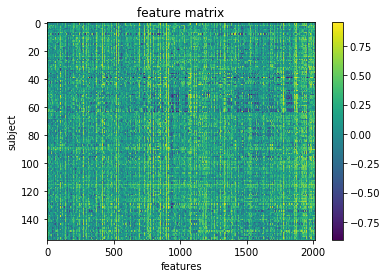

In [22]:
plt.imshow(df_features, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subject')

# Target (Labels) DataFrame for Machine Learning

In [25]:
# Convert pheno to pandas DataFrame

pheno = pd.DataFrame(pheno)
pheno.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness
0,sub-pixar123,27.06,Adult,adult,F,R
1,sub-pixar124,33.44,Adult,adult,M,R
2,sub-pixar125,31.00,Adult,adult,M,R
3,sub-pixar126,19.00,Adult,adult,F,R
4,sub-pixar127,23.00,Adult,adult,F,R


In [26]:
# Extract Gender Column to another DataFrame df_labels

df_labels = pd.DataFrame(pheno['Gender'])
df_labels

,Gender
0,F
1,M
2,M
3,F
4,F
...,...
150,F
151,F
152,F
153,F


In [27]:
# Convert Categorical Variable "Gender" to numeric 

le = preprocessing.LabelEncoder()
le.fit(df_labels.values)
print(le.classes_)
df_labels = pd.DataFrame(data=le.transform(df_labels.values),columns=['Gender'])
df_labels.head()

['F' 'M']


,Gender
0,0
1,1
2,1
3,0
4,0


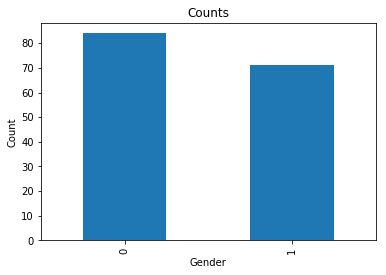

In [28]:
# Plot a Bar Chart
df_labels['Gender'].value_counts().plot(kind='bar',title='Counts')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [41]:
# Total Count of each unique value of Gender

df_labels['Gender'].value_counts()

0    84
1    71
Name: Gender, dtype: int64

In [43]:
df_combined = pd.concat([df_features,df_labels],axis=1, sort=False)
print(df_table.shape)
print(type(df_combined))
df_combined.head()


(155, 2017)
<class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6,7,8,9,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,Gender
0,0.232860,-0.043625,0.092009,0.465798,0.295241,0.091350,0.000028,-0.000019,0.000017,-0.000013,...,0.135321,0.214588,0.449405,0.231941,0.387250,0.166260,0.551690,0.378682,0.475202,0
1,0.467246,-0.119457,-0.062547,0.472326,0.376036,0.035121,0.000221,0.000038,-0.000191,0.000221,...,0.272233,-0.032882,0.391810,0.232658,0.548074,-0.242473,0.032048,0.095475,0.230578,1
2,0.448596,0.130983,0.316571,0.662571,0.272684,0.098411,-0.023168,-0.069897,0.066056,0.024636,...,0.628576,0.405334,0.591906,0.656595,0.554171,0.376697,0.512734,0.457288,0.640499,1
3,0.236547,0.048036,0.002236,0.448658,0.142590,0.068359,-0.053419,-0.029784,0.014794,0.036110,...,0.530982,0.072605,0.175955,0.194926,0.170638,0.191752,0.135061,0.135847,0.368537,0
4,0.244007,0.083132,0.342197,0.341674,-0.076095,-0.086215,0.135303,-0.107674,-0.012754,0.168019,...,0.092597,0.269093,0.413449,0.128707,0.338674,0.145776,0.345804,0.177099,0.419354,0


In [44]:
df_combined.dtypes

0         float64
1         float64
2         float64
3         float64
4         float64
           ...   
2012      float64
2013      float64
2014      float64
2015      float64
Gender      int64
Length: 2017, dtype: object

In [45]:
df_combined.Gender.unique()

array([0, 1])

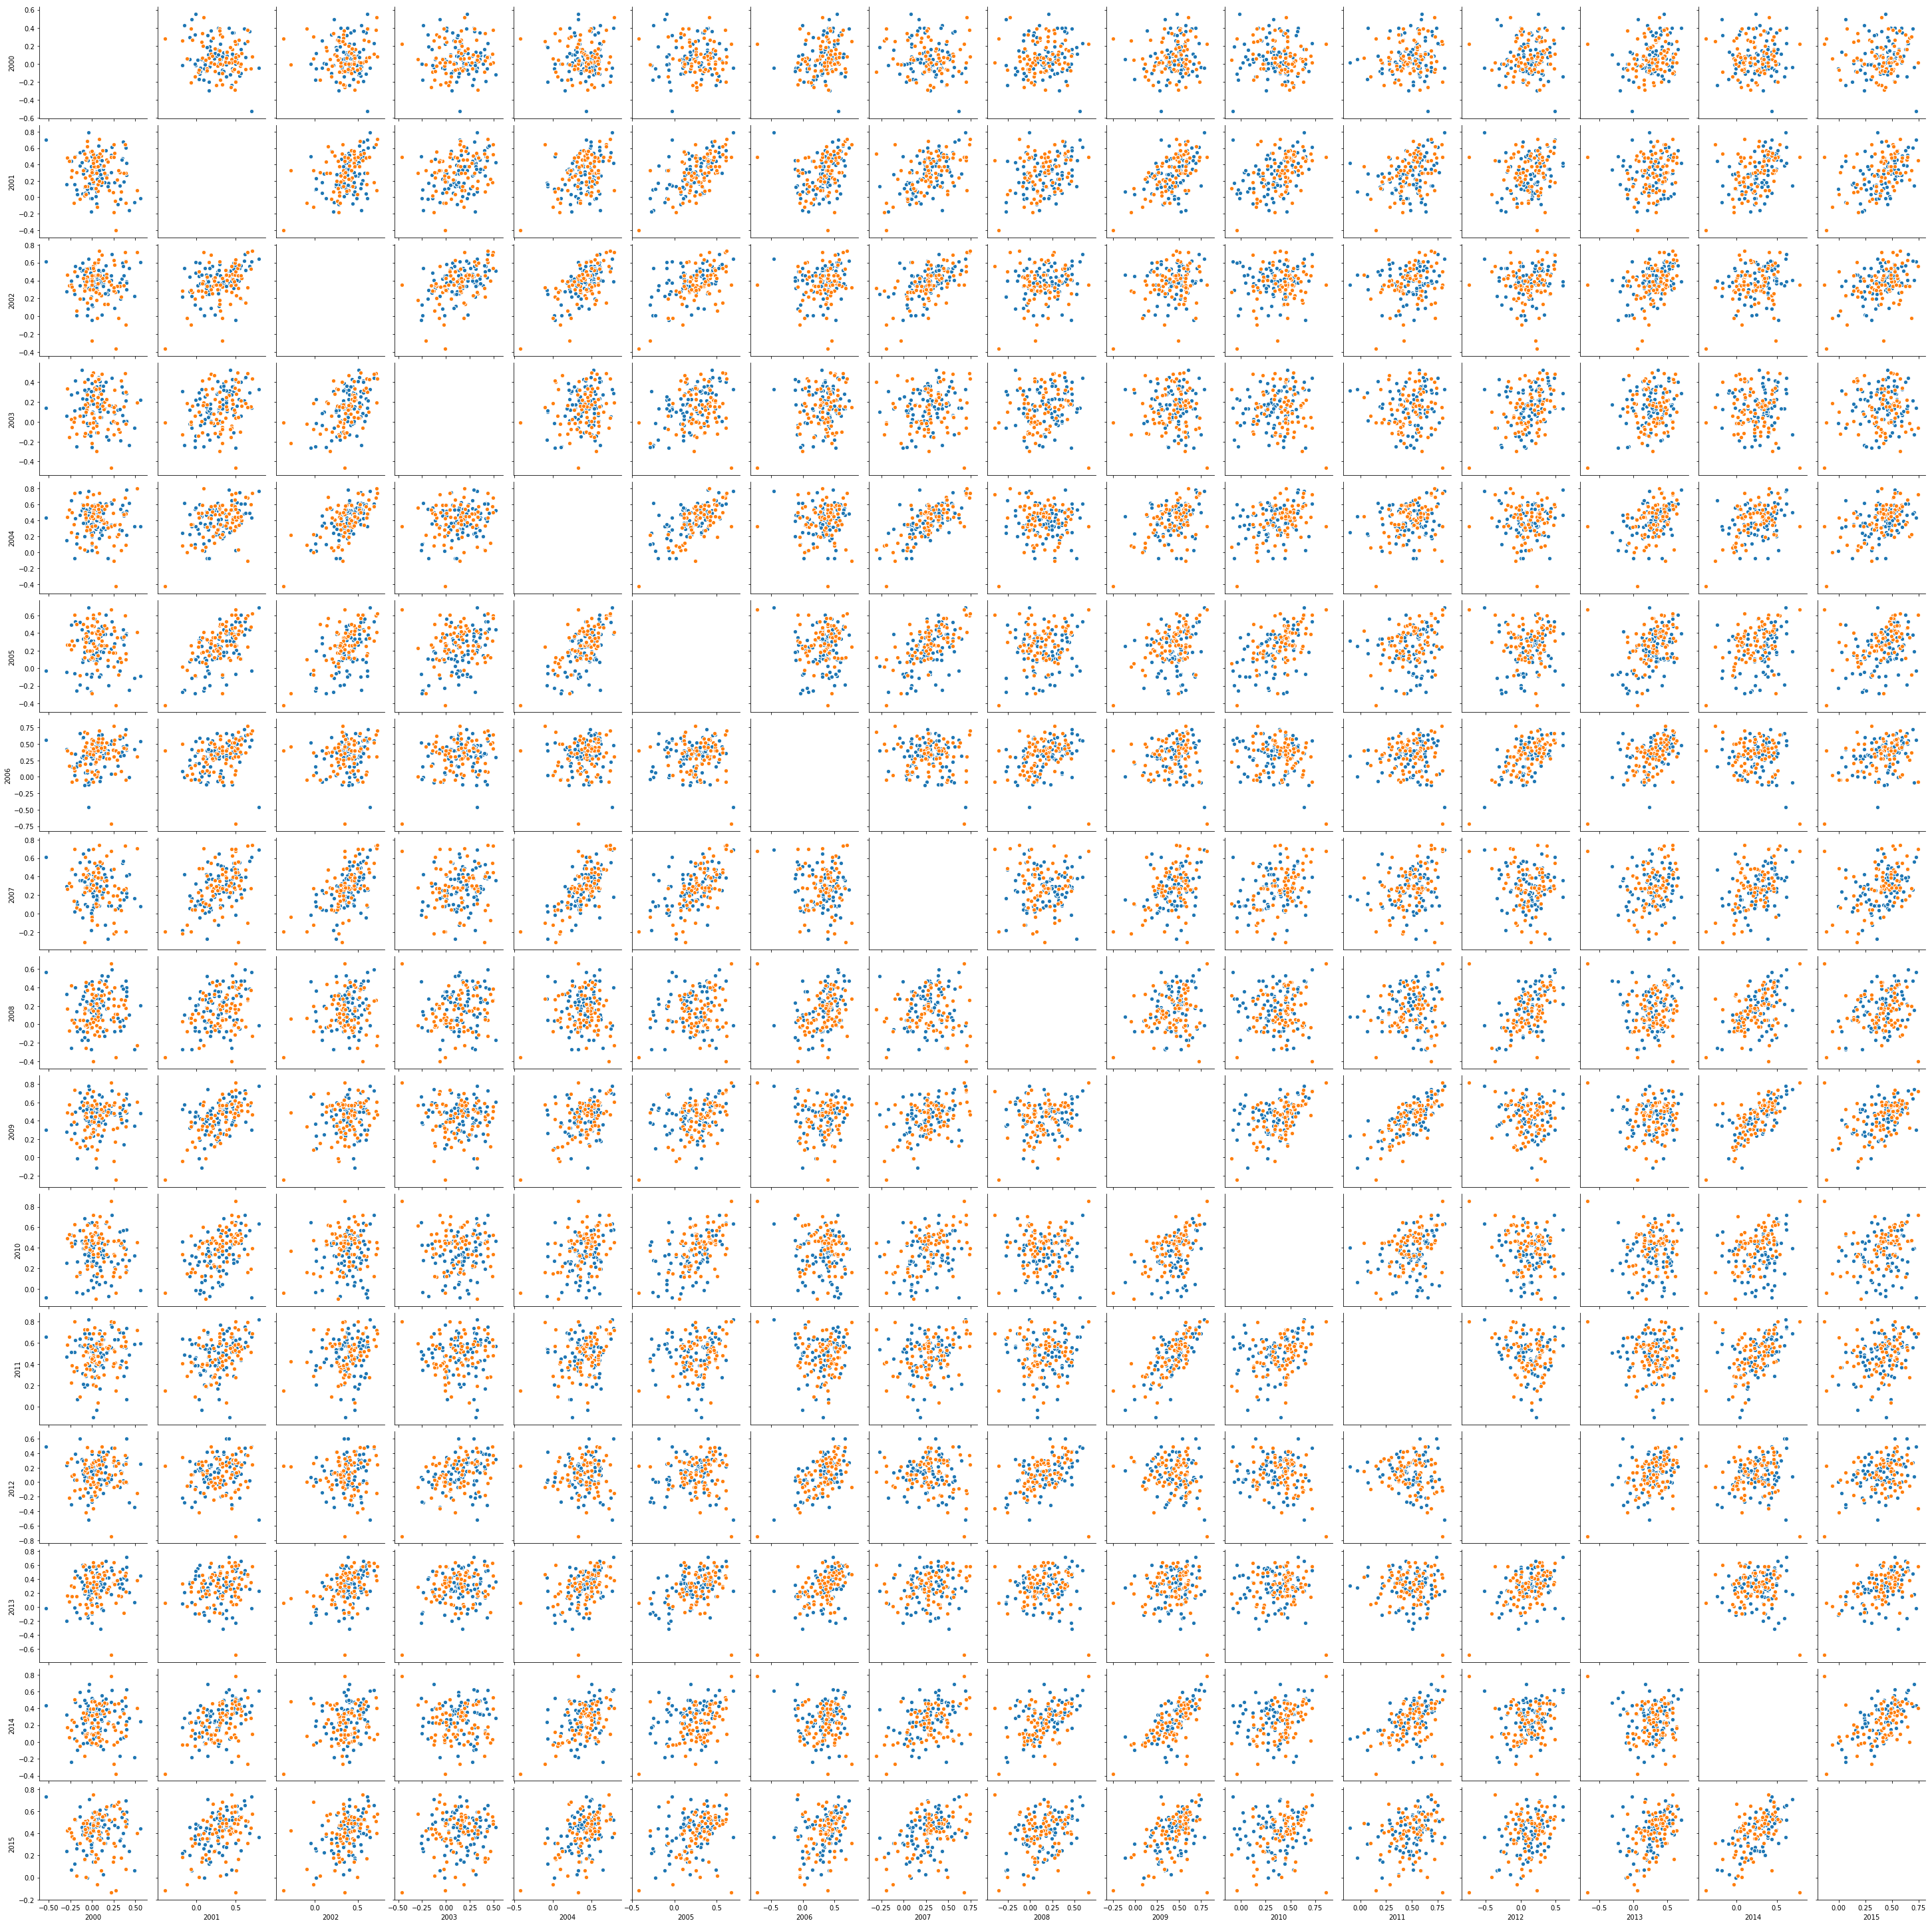

In [46]:
# Grid Plot or matrix plot
g = sns.PairGrid(df_combined.iloc[:,2000:2017], hue="Gender")
#g = g.map_diag(plt.hist, edgecolor="w") # histogram on diagonals
g = g.map_offdiag(plt.scatter, edgecolor="w", s=40) #off diagonals will be scatter plots; s=40 telling the size of grid
plt.show()

# Train/Test Set for ML

In [30]:
# Split the sample to training/validation with a 60/40 ratio, and 
# stratify by age class, and also shuffle the data.

X_train, X_val, y_train, y_val = train_test_split(
                                                    df_features, # x
                                                    df_labels.values, # y
                                                    test_size = 0.30, # 70%/30% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    stratify = df_labels.values,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

training: 108 testing: 47


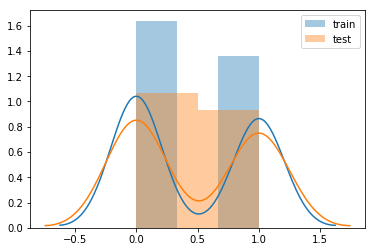

In [31]:
sns.distplot(y_train,label='train')
sns.distplot(y_val,label='test')
plt.legend()

# ML Algorithms

## Logistic Regression with leave-one-out Cross Validation

In [53]:
loo = LeaveOneOut() # for leaveOneOut cross validation

model = LogisticRegression(random_state=0) 
# predict
#y_pred = cross_val_predict(model, X_train, y_train, cv=loo)

acc = cross_val_score(model , X = X_train , y = y_train , cv = loo, scoring='accuracy') # Cross validation scores
mae = cross_val_score(model, X_train, y_train, cv=loo, scoring='neg_mean_absolute_error')

In [52]:
acc.mean() * 100

60.18518518518518

In [54]:


# predict
y_pred = cross_val_predict(model, X_train, y_train, cv=10)
# scores
acc = cross_val_score(model, X_train, y_train, cv=10)
mae = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')


In [57]:
print(acc.mean())
print(mae.mean())

0.6054545454545455
-0.39454545454545453


In [60]:
model = KNeighborsClassifier(n_neighbors = 3, metric ='manhattan',p=1)

In [61]:
# scores
acc = cross_val_score(model, X_train, y_train, cv=10)
mae = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

In [62]:
print(acc.mean())
print(mae.mean())

0.5009090909090909
-0.49909090909090914
